In [1]:
# 다음의 코드를 참고하여 재구성 : 1. https://github.com/dikshantsagar/CGAN-Face-Emotion-Generation 2. https://github.com/gaborvecsei/CDCGAN-Keras 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/My Drive/Colab Notebooks/Paper/참고) GAN/또다른거 진행

/content/drive/My Drive/Colab Notebooks/Paper/참고) GAN/또다른거 진행


In [4]:
import matplotlib
import tensorflow
matplotlib.use('Agg')
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import utils as keras_utils
from tensorflow.keras import optimizers
from tensorflow.keras import datasets
from tensorflow.keras.utils import plot_model
import cdcgan_utils

import pandas as pd
import os 
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm
import cv2
import glob

In [5]:
cd /content/drive/My Drive/Colab Notebooks/Paper

/content/drive/My Drive/Colab Notebooks/Paper


In [6]:
data_name = 'FER'
fake_classes = 100
classes=7
size = 48
input_sizes = (size,size,1)
batch_size = 128
latent_dim = 100
channels = 1
filters = 64

EPOCHS =100

In [7]:
# data import
x_train = pd.read_csv(os.path.join(data_name,'X_train.csv'),header=0,index_col=0)
x_valid = pd.read_csv(os.path.join(data_name,'X_private_test.csv'),header=0,index_col=0)
y_train = pd.read_csv(os.path.join(data_name,'y_train.csv'),header=0,index_col=0)
y_valid = pd.read_csv(os.path.join(data_name,'y_private_test.csv'),header=0,index_col=0)


# data handling
x_train = np.array(x_train).reshape([-1,48,48,3]) 
x_valid = np.array(x_valid).reshape([-1,48,48,3]) 

x_train = np.vstack([x_train,x_valid])
y_train  = np.vstack([y_train,y_valid])

# x : -1 ~ 1 centering & scaling
x_train=(x_train.astype('float32')-127.5)/127.5 
x_train=x_train[:,:,:,1]
x_train=x_train[:,:,:,np.newaxis]

In [8]:
dataset = [x_train,y_train]

In [9]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Conv2DTranspose, Embedding, Reshape, Concatenate, Dropout , LeakyReLU, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop

In [10]:
n_classes = 7
latent_dim = 100

In [11]:
def get_discriminator(filters=64,in_shape=(48,48,1), n_classes=7, channels=1):

  label = Input(shape = (1,))
  li = Embedding(n_classes+1,50)(label)

  li = Dense(in_shape[0]*in_shape[1])(li)

  li = Reshape((in_shape[0],in_shape[1],channels))(li)

  image = Input(shape=in_shape)

  merge = Concatenate()([image, li])

  fe = Conv2D(filters,(3,3), strides=(2,2), padding = 'same')(merge)
  fe = LeakyReLU(0.2)(fe)

  fe = Conv2D(filters*2, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(0.2)(fe)

  fe = Flatten()(fe)
  fe = Dropout(0.4)(fe)

  out_layer = Dense(1, activation='sigmoid')(fe)

  model = Model([image, label], out_layer)

  opt = RMSprop(lr=0.0001, decay=1e-6)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 
  return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        400         input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 2304)      117504      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 48, 48, 1)]  0                                            
______________________________________________________________________________________________

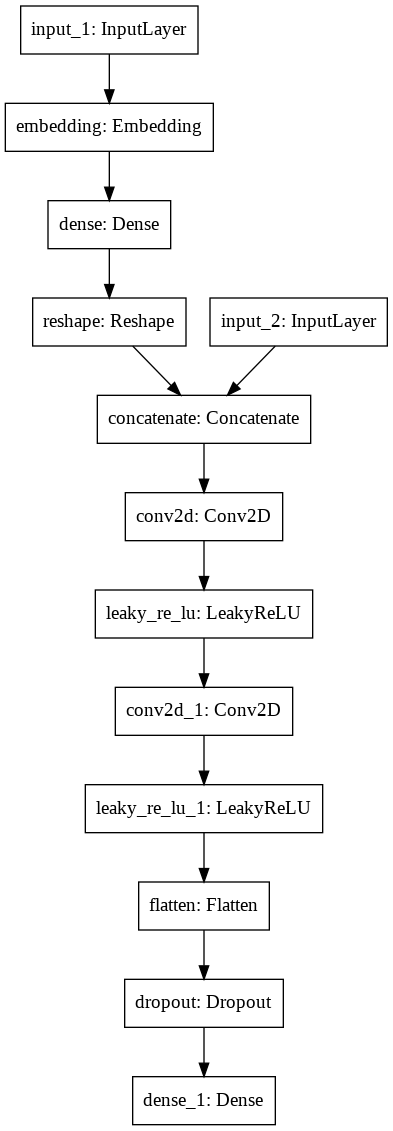

In [12]:
discmodel = get_discriminator()
discmodel.summary()
plot_model(discmodel)

In [13]:
def get_generator(filters=64, latent_dim=100, output_sizes=(48,48) , n_classes = 7, channels=1):
    label = Input(shape=(1,))

    li = Embedding(n_classes+1,50)(label)

    li = Dense(output_sizes[0] // 4 * output_sizes[1] // 4 * channels )(li) 
    li = Reshape((output_sizes[0] // 4, output_sizes[1] // 4 , channels ))(li)

    latent = Input(shape=(latent_dim,))

    gen = Dense(output_sizes[0] // 4 * output_sizes[1] // 4 * filters * 4)(latent)
    gen = LeakyReLU(0.2)(gen)
    gen = Reshape((output_sizes[0] // 4, output_sizes[1] // 4, filters * 4))(gen)

    merge = Concatenate()([gen, li])

    gen = Conv2DTranspose(filters * 2, (3,3), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(0.2)(gen)
    gen = Conv2DTranspose(filters, (3,3), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(0.2)(gen)

    out_layer = Conv2D(channels, (3,3), activation='tanh', padding='same')(gen)

    model = Model([latent, label], out_layer)
    return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 36864)        3723264     input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        400         input_3[0][0]                    
____________________________________________________________________________________________

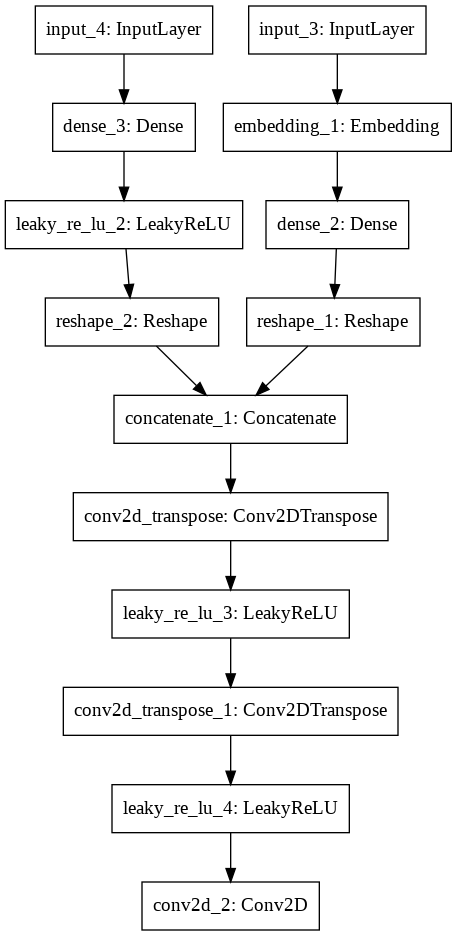

In [14]:
genmodel = get_generator(filters=filters,latent_dim=latent_dim)
genmodel.summary()
plot_model(genmodel)

In [15]:
def cgan(genmodel,discmodel):

  discmodel.trainable = False

  g_noise, g_label = genmodel.input
  g_output = genmodel.output

  cgan_output = discmodel([g_output, g_label])

  model = Model([g_noise, g_label], cgan_output)

  opt = RMSprop(lr=0.0001, decay=1e-6)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [16]:
def generate_real_samples(dataset, n_samples):
	
	images, labels = dataset

	ix = np.random.randint(0, images.shape[0], n_samples)
	
	X, labels = images[ix], labels[ix]
	
	y = np.ones((n_samples, 1))
	return [X, labels], y

In [17]:
def generate_latent_points(latent_dim, n_samples, n_classes=7):
	
	x_input = np.random.randn(latent_dim * n_samples)
	
	z_input = x_input.reshape(n_samples, latent_dim)
	
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]
 

def generate_fake_samples(generator, latent_dim, n_samples):
	
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	
	images = generator.predict([z_input, labels_input])
	
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [18]:
def train(genmodel, discmodel, cganmodel, dataset, latent_dim, n_epochs=100, n_batch=64, classes=7):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    iteration = 0


    nb_of_iterations_per_epoch = int(dataset[0].shape[0] / n_batch)
    print("Number of iterations per epoch: {0}".format(nb_of_iterations_per_epoch))
    for i in range(n_epochs):

      pbar = tqdm(desc="Epoch: {0}".format(i), total=dataset[0].shape[0])
      g_losses = []
      d1_losses = []
      d2_losses = []
      g_accuracies = []
      d1_accuracies = []
      d2_accuracies = []
      
      for j in range(bat_per_epo):
          # if j % 20 == 0:
          #     image_grid = cdcgan_utils.generate_image_grid(genmodel, title="Epoch {0}, iteration {1}".format(i,iteration) , classes=classes, gen_num_images=10, cmap='gray')
          #     cdcgan_utils.save_generated_image(image_grid, i, j, "/content/drive/My Drive/Colab Notebooks/Paper/temp/또다른거 진행/iteration")


          #display.clear_output(wait=True)
          [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
          d_loss1, d_acc1 = discmodel.train_on_batch([X_real, labels_real], y_real)
          d1_losses.append(d_loss1)
          d1_accuracies.append(d_acc1)


          [X_fake, labels], y_fake = generate_fake_samples(genmodel, latent_dim, half_batch)
          d_loss2, d_acc2 = discmodel.train_on_batch([X_fake, labels], y_fake)
          d2_losses.append(d_loss2)
          d2_accuracies.append(d_acc2)      

          [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

          y_gan = np.ones((n_batch, 1))

          g_loss, g_acc = cganmodel.train_on_batch([z_input, labels_input], y_gan)
          g_losses.append(g_loss)
          g_accuracies.append(g_acc)  

          pbar.update(batch_size)
          iteration += 1
        
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
          (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
      
      # Save a generated image for every epoch
      image_grid = cdcgan_utils.generate_image_grid(genmodel, title="Epoch {0}".format(i) , classes=classes, cmap='gray')
      cdcgan_utils.save_generated_image(image_grid, i, 0, "/content/drive/My Drive/Colab Notebooks/Paper/참고) GAN/또다른거 진행/dcgan/epoch")

      pbar.close()
      print("Number of iterations: %d "%iteration)
      print("D_real loss: {0}, D_fake loss: {1}, GD loss: {2} // D_real accuracy: {3}, D_fake accuracy: {4}, GD accuracy: {5}".format(np.mean(d1_losses), np.mean(d2_losses), np.mean(g_losses),
                                                                                                                                      np.mean(d1_accuracies), np.mean(d2_accuracies), np.mean(g_accuracies)))
      if i % 10 == 0:
          genmodel.save_weights(os.path.join("/content/drive/My Drive/Colab Notebooks/Paper/참고) GAN/또다른거 진행/dcgan/G", str(i)+".h5"))
          discmodel.save_weights(os.path.join("/content/drive/My Drive/Colab Notebooks/Paper/참고) GAN/또다른거 진행/dcgan/D", str(i)+".h5"))
      
    return d1_losses,d2_losses,g_losses,d1_accuracies,d2_accuracies,g_accuracies

In [19]:
discmodel = get_discriminator()
genmodel = get_generator(filters=filters,latent_dim=latent_dim)
#genmodel = load_model('/content/drive/My Drive/DL/cgan_generator.h5')

cganmodel = cgan(genmodel,discmodel)

In [20]:
cganmodel.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 36864)        3723264     input_8[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        400         input_7[0][0]                    
____________________________________________________________________________________________

In [21]:
# 0:Anger, 1:Disgust, 2:Fear, 3:Happiness, 4:Sadness, 5:Surprise, 6:Neutral

d1,d2,g,d1_acc,d2_acc,g_acc=train(genmodel, discmodel, cganmodel, dataset, latent_dim,n_epochs=100, n_batch=64)

Epoch: 0:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations per epoch: 504


Epoch: 0: 64384it [00:41, 1725.53it/s]

>1, 504/504, d1=0.172, d2=0.216 g=2.466


Epoch: 0: 64512it [00:42, 1529.49it/s]


Number of iterations: 504 
D_real loss: 0.3126370931406402, D_fake loss: 0.8183925149903174, GD loss: 1.203643829975691 // D_real accuracy: 0.8664434523809523, D_fake accuracy: 0.5274677579365079, GD accuracy: 0.36039806547619047


Epoch: 1: 64512it [00:38, 1735.82it/s]

>2, 504/504, d1=1.502, d2=1.042 g=0.821


Epoch: 1: 64512it [00:38, 1680.34it/s]
Epoch: 2:   1%|          | 256/32287 [00:00<00:18, 1710.77it/s]

Number of iterations: 1008 
D_real loss: 0.9545832824346329, D_fake loss: 0.9858805038892324, GD loss: 1.4084568720103965 // D_real accuracy: 0.5237475198412699, D_fake accuracy: 0.5366443452380952, GD accuracy: 0.2569444444444444


Epoch: 2: 64512it [00:37, 1713.32it/s]

>3, 504/504, d1=0.748, d2=0.759 g=0.864


Epoch: 2: 64512it [00:37, 1711.34it/s]
Epoch: 3:   1%|          | 256/32287 [00:00<00:17, 1797.07it/s]

Number of iterations: 1512 
D_real loss: 0.8565159992329658, D_fake loss: 0.7839048281311989, GD loss: 0.8964234568060391 // D_real accuracy: 0.31653025793650796, D_fake accuracy: 0.36321924603174605, GD accuracy: 0.3294270833333333


Epoch: 3: 64512it [00:37, 1730.95it/s]

>4, 504/504, d1=0.726, d2=0.720 g=1.015


Epoch: 3: 64512it [00:37, 1711.25it/s]
Epoch: 4:   1%|          | 256/32287 [00:00<00:18, 1750.91it/s]

Number of iterations: 2016 
D_real loss: 0.7071751751123913, D_fake loss: 0.7054037186834548, GD loss: 0.9016518080754886 // D_real accuracy: 0.5142609126984127, D_fake accuracy: 0.37537202380952384, GD accuracy: 0.41338045634920634


Epoch: 4: 64512it [00:37, 1746.07it/s]

>5, 504/504, d1=0.669, d2=0.664 g=1.008


Epoch: 4: 64512it [00:37, 1705.98it/s]
Epoch: 5:   1%|          | 256/32287 [00:00<00:19, 1651.62it/s]

Number of iterations: 2520 
D_real loss: 0.6664778435277561, D_fake loss: 0.6848461435191215, GD loss: 0.9065796289415586 // D_real accuracy: 0.6502976190476191, D_fake accuracy: 0.3874627976190476, GD accuracy: 0.4644097222222222


Epoch: 5: 64512it [00:37, 1725.51it/s]

>6, 504/504, d1=0.687, d2=0.697 g=0.980


Epoch: 5: 64512it [00:37, 1703.72it/s]
Epoch: 6:   1%|          | 256/32287 [00:00<00:18, 1744.57it/s]

Number of iterations: 3024 
D_real loss: 0.6308961774385164, D_fake loss: 0.682798169967201, GD loss: 0.9331750461742991 // D_real accuracy: 0.7465897817460317, D_fake accuracy: 0.3931051587301587, GD accuracy: 0.498046875


Epoch: 6: 64512it [00:37, 1682.54it/s]

>7, 504/504, d1=0.372, d2=0.567 g=1.010


Epoch: 6: 64512it [00:37, 1705.97it/s]
Epoch: 7:   1%|          | 256/32287 [00:00<00:19, 1678.98it/s]

Number of iterations: 3528 
D_real loss: 0.6099717770777051, D_fake loss: 0.701780510859357, GD loss: 0.9433108823640006 // D_real accuracy: 0.7508060515873016, D_fake accuracy: 0.37524801587301587, GD accuracy: 0.5026971726190477


Epoch: 7: 64512it [00:37, 1643.29it/s]

>8, 504/504, d1=0.440, d2=0.805 g=0.893


Epoch: 7: 64512it [00:37, 1700.74it/s]
Epoch: 8:   1%|          | 256/32287 [00:00<00:17, 1781.95it/s]

Number of iterations: 4032 
D_real loss: 0.618831004651766, D_fake loss: 0.7276157915355668, GD loss: 0.9451143363165477 // D_real accuracy: 0.7101314484126984, D_fake accuracy: 0.37506200396825395, GD accuracy: 0.5021081349206349


Epoch: 8: 64512it [00:37, 1731.82it/s]

>9, 504/504, d1=0.720, d2=0.726 g=0.855


Epoch: 8: 64512it [00:37, 1713.23it/s]
Epoch: 9:   1%|          | 256/32287 [00:00<00:17, 1804.55it/s]

Number of iterations: 4536 
D_real loss: 0.6709376920073752, D_fake loss: 0.7003654203717671, GD loss: 0.9058765959408548 // D_real accuracy: 0.6375248015873016, D_fake accuracy: 0.35584077380952384, GD accuracy: 0.5328621031746031


Epoch: 9: 64512it [00:37, 1708.24it/s]

>10, 504/504, d1=0.780, d2=0.727 g=0.796


Epoch: 9: 64512it [00:37, 1709.24it/s]
Epoch: 10:   1%|          | 256/32287 [00:00<00:17, 1781.27it/s]

Number of iterations: 5040 
D_real loss: 0.6665645697050624, D_fake loss: 0.6893036283907437, GD loss: 0.9103866648815927 // D_real accuracy: 0.6299603174603174, D_fake accuracy: 0.38318452380952384, GD accuracy: 0.507843501984127


Epoch: 10: 64512it [00:37, 1741.17it/s]

>11, 504/504, d1=0.640, d2=0.623 g=0.946


Epoch: 10: 64512it [00:37, 1717.41it/s]
Epoch: 11:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations: 5544 
D_real loss: 0.6650434298411249, D_fake loss: 0.6822764104793942, GD loss: 0.9124969219168028 // D_real accuracy: 0.6413070436507936, D_fake accuracy: 0.39955357142857145, GD accuracy: 0.4969618055555556


Epoch: 11: 64512it [00:37, 1714.26it/s]

>12, 504/504, d1=0.623, d2=0.705 g=0.985


Epoch: 11: 64512it [00:37, 1713.73it/s]
Epoch: 12:   1%|          | 256/32287 [00:00<00:17, 1803.81it/s]

Number of iterations: 6048 
D_real loss: 0.6595662944610157, D_fake loss: 0.6759563296560257, GD loss: 0.9182061349588727 // D_real accuracy: 0.6668526785714286, D_fake accuracy: 0.38101438492063494, GD accuracy: 0.5206163194444444


Epoch: 12: 64512it [00:37, 1763.07it/s]

>13, 504/504, d1=0.606, d2=0.721 g=0.864


Epoch: 12: 64512it [00:37, 1731.47it/s]
Epoch: 13:   1%|          | 256/32287 [00:00<00:18, 1778.55it/s]

Number of iterations: 6552 
D_real loss: 0.6592012672197252, D_fake loss: 0.6745763279142833, GD loss: 0.9124271361127733 // D_real accuracy: 0.6708209325396826, D_fake accuracy: 0.37983630952380953, GD accuracy: 0.5212053571428571


Epoch: 13: 64512it [00:37, 1668.59it/s]

>14, 504/504, d1=0.625, d2=0.685 g=0.859


Epoch: 13: 64512it [00:37, 1702.54it/s]
Epoch: 14:   1%|          | 256/32287 [00:00<00:18, 1726.44it/s]

Number of iterations: 7056 
D_real loss: 0.6528786255253686, D_fake loss: 0.6709355081594179, GD loss: 0.9171156164199586 // D_real accuracy: 0.691468253968254, D_fake accuracy: 0.37890625, GD accuracy: 0.5313430059523809


Epoch: 14: 64512it [00:37, 1757.57it/s]

>15, 504/504, d1=0.669, d2=0.657 g=0.887


Epoch: 14: 64512it [00:37, 1704.84it/s]
Epoch: 15:   1%|          | 256/32287 [00:00<00:18, 1715.96it/s]

Number of iterations: 7560 
D_real loss: 0.6531536599236821, D_fake loss: 0.671499310859612, GD loss: 0.9140146938817841 // D_real accuracy: 0.7085193452380952, D_fake accuracy: 0.3820684523809524, GD accuracy: 0.5301959325396826


Epoch: 15: 64512it [00:38, 1702.33it/s]

>16, 504/504, d1=0.632, d2=0.667 g=0.850


Epoch: 15: 64512it [00:38, 1659.45it/s]
Epoch: 16:   1%|          | 256/32287 [00:00<00:17, 1791.69it/s]

Number of iterations: 8064 
D_real loss: 0.6528816024462382, D_fake loss: 0.6708869246972932, GD loss: 0.9202410851915678 // D_real accuracy: 0.7115575396825397, D_fake accuracy: 0.38175843253968256, GD accuracy: 0.525452628968254


Epoch: 16: 64512it [00:37, 1748.45it/s]

>17, 504/504, d1=0.723, d2=0.652 g=0.924


Epoch: 16: 64512it [00:37, 1706.52it/s]
Epoch: 17:   1%|          | 256/32287 [00:00<00:19, 1684.44it/s]

Number of iterations: 8568 
D_real loss: 0.6483524026615279, D_fake loss: 0.6661652069952753, GD loss: 0.9264011211575024 // D_real accuracy: 0.6960565476190477, D_fake accuracy: 0.4244791666666667, GD accuracy: 0.4976438492063492


Epoch: 17: 64512it [00:37, 1753.15it/s]

>18, 504/504, d1=0.679, d2=0.710 g=0.933


Epoch: 17: 64512it [00:37, 1710.53it/s]
Epoch: 18:   1%|          | 256/32287 [00:00<00:18, 1712.38it/s]

Number of iterations: 9072 
D_real loss: 0.6461221917517601, D_fake loss: 0.6659870532060427, GD loss: 0.9219522443082597 // D_real accuracy: 0.7020709325396826, D_fake accuracy: 0.4388640873015873, GD accuracy: 0.48549107142857145


Epoch: 18: 64512it [00:37, 1756.14it/s]

>19, 504/504, d1=0.664, d2=0.715 g=0.849


Epoch: 18: 64512it [00:37, 1721.66it/s]
Epoch: 19:   1%|          | 256/32287 [00:00<00:18, 1707.90it/s]

Number of iterations: 9576 
D_real loss: 0.6456067110337909, D_fake loss: 0.6666296899082169, GD loss: 0.9240418654822168 // D_real accuracy: 0.7194320436507936, D_fake accuracy: 0.4166046626984127, GD accuracy: 0.5044642857142857


Epoch: 19: 64512it [00:36, 1779.99it/s]

>20, 504/504, d1=0.662, d2=0.596 g=0.977


Epoch: 19: 64512it [00:37, 1734.95it/s]
Epoch: 20:   1%|          | 256/32287 [00:00<00:18, 1742.52it/s]

Number of iterations: 10080 
D_real loss: 0.6461457073215454, D_fake loss: 0.6667505361967616, GD loss: 0.9148262792399952 // D_real accuracy: 0.7225322420634921, D_fake accuracy: 0.4146205357142857, GD accuracy: 0.5179811507936508


Epoch: 20: 64512it [00:36, 1756.24it/s]

>21, 504/504, d1=0.675, d2=0.706 g=0.990


Epoch: 20: 64512it [00:37, 1735.43it/s]
Epoch: 21:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations: 10584 
D_real loss: 0.6413854325101489, D_fake loss: 0.6629546762458862, GD loss: 0.9350840946038564 // D_real accuracy: 0.7059151785714286, D_fake accuracy: 0.4441344246031746, GD accuracy: 0.4900173611111111


Epoch: 21: 64512it [00:37, 1724.38it/s]

>22, 504/504, d1=0.698, d2=0.567 g=0.892


Epoch: 21: 64512it [00:37, 1731.30it/s]
Epoch: 22:   1%|          | 256/32287 [00:00<00:19, 1648.48it/s]

Number of iterations: 11088 
D_real loss: 0.6437343986971038, D_fake loss: 0.6644699553412104, GD loss: 0.9360791093536786 // D_real accuracy: 0.7261284722222222, D_fake accuracy: 0.41381448412698413, GD accuracy: 0.5146329365079365


Epoch: 22: 64512it [00:37, 1745.02it/s]

>23, 504/504, d1=0.635, d2=0.636 g=0.977


Epoch: 22: 64512it [00:37, 1727.76it/s]
Epoch: 23:   1%|          | 256/32287 [00:00<00:17, 1792.37it/s]

Number of iterations: 11592 
D_real loss: 0.6436203648410146, D_fake loss: 0.6658814275075519, GD loss: 0.9342671740386221 // D_real accuracy: 0.7406374007936508, D_fake accuracy: 0.39806547619047616, GD accuracy: 0.5443638392857143


Epoch: 23: 64512it [00:37, 1735.37it/s]

>24, 504/504, d1=0.595, d2=0.657 g=0.852


Epoch: 23: 64512it [00:37, 1706.87it/s]
Epoch: 24:   1%|          | 256/32287 [00:00<00:18, 1700.42it/s]

Number of iterations: 12096 
D_real loss: 0.649146640348056, D_fake loss: 0.6680232533031986, GD loss: 0.920276678389027 // D_real accuracy: 0.7135416666666666, D_fake accuracy: 0.4000496031746032, GD accuracy: 0.529358878968254


Epoch: 24: 64512it [00:37, 1762.09it/s]

>25, 504/504, d1=0.640, d2=0.721 g=0.980


Epoch: 24: 64512it [00:37, 1730.91it/s]
Epoch: 25:   1%|          | 256/32287 [00:00<00:17, 1807.29it/s]

Number of iterations: 12600 
D_real loss: 0.6445724487541213, D_fake loss: 0.667744615011745, GD loss: 0.9203795228922178 // D_real accuracy: 0.7416914682539683, D_fake accuracy: 0.3781622023809524, GD accuracy: 0.5576016865079365


Epoch: 25: 64512it [00:37, 1688.44it/s]

>26, 504/504, d1=0.593, d2=0.692 g=0.910


Epoch: 25: 64512it [00:37, 1724.24it/s]
Epoch: 26:   1%|          | 256/32287 [00:00<00:17, 1786.04it/s]

Number of iterations: 13104 
D_real loss: 0.6462803293788244, D_fake loss: 0.6675371932131904, GD loss: 0.9210548156074115 // D_real accuracy: 0.7386532738095238, D_fake accuracy: 0.38721478174603174, GD accuracy: 0.5557415674603174


Epoch: 26: 64512it [00:37, 1739.70it/s]

>27, 504/504, d1=0.665, d2=0.637 g=0.742


Epoch: 26: 64512it [00:37, 1702.03it/s]
Epoch: 27:   1%|          | 256/32287 [00:00<00:18, 1753.15it/s]

Number of iterations: 13608 
D_real loss: 0.6452591583605797, D_fake loss: 0.6676069676639542, GD loss: 0.9399743177114971 // D_real accuracy: 0.7404513888888888, D_fake accuracy: 0.39248511904761907, GD accuracy: 0.5477740575396826


Epoch: 27: 64512it [00:37, 1736.60it/s]

>28, 504/504, d1=0.635, d2=0.654 g=0.973


Epoch: 27: 64512it [00:37, 1729.17it/s]
Epoch: 28:   1%|          | 256/32287 [00:00<00:17, 1784.25it/s]

Number of iterations: 14112 
D_real loss: 0.6482389802261005, D_fake loss: 0.668127098135532, GD loss: 0.9183023242013795 // D_real accuracy: 0.7154637896825397, D_fake accuracy: 0.41592261904761907, GD accuracy: 0.5180121527777778


Epoch: 28: 64512it [00:37, 1681.20it/s]

>29, 504/504, d1=0.718, d2=0.657 g=0.953


Epoch: 28: 64512it [00:37, 1723.33it/s]
Epoch: 29:   1%|          | 256/32287 [00:00<00:18, 1754.67it/s]

Number of iterations: 14616 
D_real loss: 0.6473790311387607, D_fake loss: 0.664626829444416, GD loss: 0.9282279382385905 // D_real accuracy: 0.7326388888888888, D_fake accuracy: 0.39794146825396826, GD accuracy: 0.5370163690476191


Epoch: 29: 64512it [00:37, 1767.91it/s]

>30, 504/504, d1=0.584, d2=0.673 g=0.838


Epoch: 29: 64512it [00:37, 1708.14it/s]
Epoch: 30:   1%|          | 256/32287 [00:00<00:18, 1770.22it/s]

Number of iterations: 15120 
D_real loss: 0.6449468562763835, D_fake loss: 0.6672599442776234, GD loss: 0.9295461611851813 // D_real accuracy: 0.724578373015873, D_fake accuracy: 0.4068700396825397, GD accuracy: 0.5270027281746031


Epoch: 30: 64512it [00:37, 1711.06it/s]

>31, 504/504, d1=0.624, d2=0.712 g=0.848


Epoch: 30: 64512it [00:37, 1725.26it/s]
Epoch: 31:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations: 15624 
D_real loss: 0.6503754602301688, D_fake loss: 0.6686499136544409, GD loss: 0.9162687079774009 // D_real accuracy: 0.7211061507936508, D_fake accuracy: 0.40234375, GD accuracy: 0.5302269345238095


Epoch: 31: 64512it [00:37, 1764.10it/s]

>32, 504/504, d1=0.603, d2=0.727 g=1.027


Epoch: 31: 64512it [00:38, 1697.26it/s]
Epoch: 32:   1%|          | 256/32287 [00:00<00:18, 1735.72it/s]

Number of iterations: 16128 
D_real loss: 0.6466840888772692, D_fake loss: 0.6665970171018253, GD loss: 0.9245789408210724 // D_real accuracy: 0.738343253968254, D_fake accuracy: 0.4015997023809524, GD accuracy: 0.5438988095238095


Epoch: 32: 64512it [00:37, 1678.32it/s]

>33, 504/504, d1=0.710, d2=0.635 g=0.933


Epoch: 32: 64512it [00:37, 1718.06it/s]
Epoch: 33:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations: 16632 
D_real loss: 0.6431782329602848, D_fake loss: 0.6636847013991977, GD loss: 0.9434461975618015 // D_real accuracy: 0.7168898809523809, D_fake accuracy: 0.4283854166666667, GD accuracy: 0.5138578869047619


Epoch: 33: 64384it [00:37, 1735.59it/s]

>34, 504/504, d1=0.699, d2=0.625 g=0.975


Epoch: 33: 64512it [00:38, 1690.26it/s]
Epoch: 34:   1%|          | 256/32287 [00:00<00:17, 1802.56it/s]

Number of iterations: 17136 
D_real loss: 0.6471390208554646, D_fake loss: 0.6639060415918865, GD loss: 0.9255845180106541 // D_real accuracy: 0.7043650793650794, D_fake accuracy: 0.44134424603174605, GD accuracy: 0.5027591765873016


Epoch: 34: 64512it [00:37, 1664.72it/s]

>35, 504/504, d1=0.659, d2=0.659 g=0.978


Epoch: 34: 64512it [00:37, 1722.82it/s]
Epoch: 35:   1%|          | 256/32287 [00:00<00:18, 1693.33it/s]

Number of iterations: 17640 
D_real loss: 0.6495789243351846, D_fake loss: 0.665795308138643, GD loss: 0.909625514868706 // D_real accuracy: 0.695374503968254, D_fake accuracy: 0.44134424603174605, GD accuracy: 0.4954737103174603


Epoch: 35: 64512it [00:37, 1752.66it/s]

>36, 504/504, d1=0.675, d2=0.688 g=0.946


Epoch: 35: 64512it [00:37, 1698.41it/s]
Epoch: 36:   1%|          | 256/32287 [00:00<00:19, 1634.67it/s]

Number of iterations: 18144 
D_real loss: 0.6466640348708819, D_fake loss: 0.6653132364153862, GD loss: 0.9263278377198038 // D_real accuracy: 0.69140625, D_fake accuracy: 0.44140625, GD accuracy: 0.49798487103174605


Epoch: 36: 64512it [00:37, 1703.73it/s]

>37, 504/504, d1=0.669, d2=0.639 g=0.926


Epoch: 36: 64512it [00:37, 1709.80it/s]
Epoch: 37:   1%|          | 256/32287 [00:00<00:18, 1719.32it/s]

Number of iterations: 18648 
D_real loss: 0.649316856075847, D_fake loss: 0.6674706181363453, GD loss: 0.9217330876087385 // D_real accuracy: 0.6870039682539683, D_fake accuracy: 0.44407242063492064, GD accuracy: 0.4995969742063492


Epoch: 37: 64512it [00:37, 1731.59it/s]

>38, 504/504, d1=0.570, d2=0.670 g=0.900


Epoch: 37: 64512it [00:37, 1704.21it/s]
Epoch: 38:   1%|          | 256/32287 [00:00<00:18, 1725.19it/s]

Number of iterations: 19152 
D_real loss: 0.6491157397154778, D_fake loss: 0.6672254438911166, GD loss: 0.9146226047286912 // D_real accuracy: 0.6963665674603174, D_fake accuracy: 0.43235367063492064, GD accuracy: 0.5128038194444444


Epoch: 38: 64512it [00:37, 1719.55it/s]

>39, 504/504, d1=0.621, d2=0.714 g=0.855


Epoch: 38: 64512it [00:37, 1710.40it/s]
Epoch: 39:   1%|          | 256/32287 [00:00<00:18, 1718.08it/s]

Number of iterations: 19656 
D_real loss: 0.6500573466931071, D_fake loss: 0.6679561058916743, GD loss: 0.9162070598630678 // D_real accuracy: 0.6814236111111112, D_fake accuracy: 0.4476066468253968, GD accuracy: 0.503875248015873


Epoch: 39: 64512it [00:37, 1676.48it/s]

>40, 504/504, d1=0.662, d2=0.647 g=0.775


Epoch: 39: 64512it [00:38, 1695.71it/s]
Epoch: 40:   1%|          | 256/32287 [00:00<00:18, 1699.01it/s]

Number of iterations: 20160 
D_real loss: 0.6495302365649314, D_fake loss: 0.6671446266155394, GD loss: 0.9183689333380215 // D_real accuracy: 0.6922123015873016, D_fake accuracy: 0.43074156746031744, GD accuracy: 0.525390625


Epoch: 40: 64512it [00:37, 1785.64it/s]

>41, 504/504, d1=0.806, d2=0.685 g=0.877


Epoch: 40: 64512it [00:37, 1714.21it/s]
Epoch: 41:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations: 20664 
D_real loss: 0.65177702548958, D_fake loss: 0.6681779135787298, GD loss: 0.916355561169367 // D_real accuracy: 0.6858878968253969, D_fake accuracy: 0.4189608134920635, GD accuracy: 0.5224144345238095


Epoch: 41: 64512it [00:37, 1707.45it/s]

>42, 504/504, d1=0.757, d2=0.571 g=0.941


Epoch: 41: 64512it [00:37, 1703.17it/s]
Epoch: 42:   1%|          | 256/32287 [00:00<00:17, 1794.26it/s]

Number of iterations: 21168 
D_real loss: 0.6519744338260757, D_fake loss: 0.668650162953233, GD loss: 0.9212764648218004 // D_real accuracy: 0.6743551587301587, D_fake accuracy: 0.44494047619047616, GD accuracy: 0.5026041666666666


Epoch: 42: 64512it [00:37, 1725.99it/s]

>43, 504/504, d1=0.612, d2=0.616 g=0.994


Epoch: 42: 64512it [00:37, 1727.30it/s]
Epoch: 43:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations: 21672 
D_real loss: 0.6498909226012608, D_fake loss: 0.6677727576286073, GD loss: 0.9310646562112702 // D_real accuracy: 0.6970486111111112, D_fake accuracy: 0.4177827380952381, GD accuracy: 0.5340401785714286


Epoch: 43: 64384it [00:37, 1646.48it/s]

>44, 504/504, d1=0.631, d2=0.674 g=0.905


Epoch: 43: 64512it [00:37, 1716.84it/s]
Epoch: 44:   1%|          | 256/32287 [00:00<00:17, 1798.87it/s]

Number of iterations: 22176 
D_real loss: 0.6522332306892152, D_fake loss: 0.6698107861337208, GD loss: 0.9103123397817687 // D_real accuracy: 0.6764632936507936, D_fake accuracy: 0.44568452380952384, GD accuracy: 0.5139818948412699


Epoch: 44: 64512it [00:37, 1715.40it/s]

>45, 504/504, d1=0.660, d2=0.670 g=0.887


Epoch: 44: 64512it [00:37, 1732.98it/s]
Epoch: 45:   1%|          | 256/32287 [00:00<00:17, 1782.43it/s]

Number of iterations: 22680 
D_real loss: 0.6513839571012391, D_fake loss: 0.6696435548365116, GD loss: 0.9207632899993942 // D_real accuracy: 0.6690228174603174, D_fake accuracy: 0.44289434523809523, GD accuracy: 0.5049913194444444


Epoch: 45: 64512it [00:37, 1752.29it/s]

>46, 504/504, d1=0.661, d2=0.725 g=1.074


Epoch: 45: 64512it [00:37, 1718.93it/s]
Epoch: 46:   1%|          | 256/32287 [00:00<00:18, 1761.90it/s]

Number of iterations: 23184 
D_real loss: 0.6546607222112398, D_fake loss: 0.6698041400975652, GD loss: 0.91838534412876 // D_real accuracy: 0.6743551587301587, D_fake accuracy: 0.43563988095238093, GD accuracy: 0.5142299107142857


Epoch: 46: 64512it [00:37, 1711.85it/s]

>47, 504/504, d1=0.608, d2=0.622 g=1.037


Epoch: 46: 64512it [00:37, 1725.59it/s]
Epoch: 47:   1%|          | 256/32287 [00:00<00:18, 1724.96it/s]

Number of iterations: 23688 
D_real loss: 0.6541935577988625, D_fake loss: 0.6697404515885171, GD loss: 0.9115992854275401 // D_real accuracy: 0.6674107142857143, D_fake accuracy: 0.4489087301587302, GD accuracy: 0.5041232638888888


Epoch: 47: 64512it [00:38, 1639.37it/s]

>48, 504/504, d1=0.600, d2=0.578 g=0.987


Epoch: 47: 64512it [00:39, 1646.16it/s]
Epoch: 48:   1%|          | 256/32287 [00:00<00:20, 1543.48it/s]

Number of iterations: 24192 
D_real loss: 0.6493305818192543, D_fake loss: 0.6673405880019778, GD loss: 0.9303129434822097 // D_real accuracy: 0.6717509920634921, D_fake accuracy: 0.4516989087301587, GD accuracy: 0.5135168650793651


Epoch: 48: 64512it [00:39, 1703.03it/s]

>49, 504/504, d1=0.612, d2=0.606 g=1.038


Epoch: 48: 64512it [00:39, 1641.96it/s]
Epoch: 49:   1%|          | 256/32287 [00:00<00:17, 1803.15it/s]

Number of iterations: 24696 
D_real loss: 0.650133863209732, D_fake loss: 0.6693618913728093, GD loss: 0.9221107271455583 // D_real accuracy: 0.6857018849206349, D_fake accuracy: 0.44419642857142855, GD accuracy: 0.5207713293650794


Epoch: 49: 64512it [00:38, 1707.58it/s]

>50, 504/504, d1=0.639, d2=0.713 g=0.790


Epoch: 49: 64512it [00:38, 1663.92it/s]
Epoch: 50:   1%|          | 256/32287 [00:00<00:18, 1732.12it/s]

Number of iterations: 25200 
D_real loss: 0.6524944320794136, D_fake loss: 0.6680032613258513, GD loss: 0.9193912070421946 // D_real accuracy: 0.6838417658730159, D_fake accuracy: 0.4267733134920635, GD accuracy: 0.5323660714285714


Epoch: 50: 64512it [00:38, 1724.28it/s]

>51, 504/504, d1=0.679, d2=0.642 g=0.986


Epoch: 50: 64512it [00:38, 1662.23it/s]
Epoch: 51:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations: 25704 
D_real loss: 0.6500035343425614, D_fake loss: 0.6683785778189463, GD loss: 0.9384784149745155 // D_real accuracy: 0.7060391865079365, D_fake accuracy: 0.41703869047619047, GD accuracy: 0.5323660714285714


Epoch: 51: 64512it [00:38, 1672.29it/s]

>52, 504/504, d1=0.665, d2=0.659 g=0.979


Epoch: 51: 64512it [00:39, 1644.63it/s]
Epoch: 52:   1%|          | 256/32287 [00:00<00:19, 1680.70it/s]

Number of iterations: 26208 
D_real loss: 0.6549252397011197, D_fake loss: 0.6691343010891051, GD loss: 0.9153063179008545 // D_real accuracy: 0.6801215277777778, D_fake accuracy: 0.43253968253968256, GD accuracy: 0.5188802083333334


Epoch: 52: 64512it [00:39, 1613.13it/s]

>53, 504/504, d1=0.603, d2=0.761 g=0.825


Epoch: 52: 64512it [00:39, 1640.55it/s]
Epoch: 53:   1%|          | 256/32287 [00:00<00:19, 1616.03it/s]

Number of iterations: 26712 
D_real loss: 0.6500682079839328, D_fake loss: 0.6696549587779574, GD loss: 0.9209926976334482 // D_real accuracy: 0.7039930555555556, D_fake accuracy: 0.41629464285714285, GD accuracy: 0.5383804563492064


Epoch: 53: 64512it [00:38, 1635.21it/s]

>54, 504/504, d1=0.616, d2=0.669 g=0.933


Epoch: 53: 64512it [00:38, 1655.02it/s]
Epoch: 54:   1%|          | 256/32287 [00:00<00:18, 1696.82it/s]

Number of iterations: 27216 
D_real loss: 0.6497588906259764, D_fake loss: 0.6695632766636591, GD loss: 0.9220489988487864 // D_real accuracy: 0.7035590277777778, D_fake accuracy: 0.4066840277777778, GD accuracy: 0.5451698908730159


Epoch: 54: 64512it [00:38, 1612.65it/s]

>55, 504/504, d1=0.628, d2=0.722 g=1.018


Epoch: 54: 64512it [00:38, 1658.51it/s]
Epoch: 55:   1%|          | 256/32287 [00:00<00:20, 1582.24it/s]

Number of iterations: 27720 
D_real loss: 0.6524828861630152, D_fake loss: 0.6686646343460159, GD loss: 0.9226510691500845 // D_real accuracy: 0.7080233134920635, D_fake accuracy: 0.41716269841269843, GD accuracy: 0.5474950396825397


Epoch: 55: 64512it [00:38, 1626.49it/s]

>56, 504/504, d1=0.618, d2=0.615 g=0.862


Epoch: 55: 64512it [00:39, 1648.38it/s]
Epoch: 56:   1%|          | 256/32287 [00:00<00:19, 1610.50it/s]

Number of iterations: 28224 
D_real loss: 0.6527052318292951, D_fake loss: 0.6686465345204823, GD loss: 0.9132138269524726 // D_real accuracy: 0.689484126984127, D_fake accuracy: 0.43936011904761907, GD accuracy: 0.5245845734126984


Epoch: 56: 64512it [00:38, 1725.81it/s]

>57, 504/504, d1=0.612, d2=0.651 g=0.931


Epoch: 56: 64512it [00:39, 1653.63it/s]
Epoch: 57:   1%|          | 256/32287 [00:00<00:18, 1762.67it/s]

Number of iterations: 28728 
D_real loss: 0.6530667339998578, D_fake loss: 0.6682109926191587, GD loss: 0.906820537552001 // D_real accuracy: 0.6895461309523809, D_fake accuracy: 0.4479166666666667, GD accuracy: 0.5190352182539683


Epoch: 57: 64512it [00:37, 1649.36it/s]

>58, 504/504, d1=0.636, d2=0.559 g=0.865


Epoch: 57: 64512it [00:37, 1704.27it/s]
Epoch: 58:   1%|          | 256/32287 [00:00<00:18, 1763.59it/s]

Number of iterations: 29232 
D_real loss: 0.6495430713135099, D_fake loss: 0.6677738130092621, GD loss: 0.9239855485539588 // D_real accuracy: 0.6985987103174603, D_fake accuracy: 0.4252232142857143, GD accuracy: 0.5356212797619048


Epoch: 58: 64512it [00:38, 1654.29it/s]

>59, 504/504, d1=0.637, d2=0.726 g=0.942


Epoch: 58: 64512it [00:38, 1685.92it/s]
Epoch: 59:   1%|          | 256/32287 [00:00<00:18, 1769.11it/s]

Number of iterations: 29736 
D_real loss: 0.6501717277699046, D_fake loss: 0.6707477644085884, GD loss: 0.9242487971981367 // D_real accuracy: 0.7155257936507936, D_fake accuracy: 0.4154265873015873, GD accuracy: 0.5472470238095238


Epoch: 59: 64512it [00:38, 1691.01it/s]

>60, 504/504, d1=0.630, d2=0.601 g=0.919


Epoch: 59: 64512it [00:38, 1670.21it/s]
Epoch: 60:   1%|          | 256/32287 [00:00<00:18, 1778.59it/s]

Number of iterations: 30240 
D_real loss: 0.6500908628342643, D_fake loss: 0.6677188500761986, GD loss: 0.9168867905225072 // D_real accuracy: 0.7127976190476191, D_fake accuracy: 0.42590525793650796, GD accuracy: 0.5443018353174603


Epoch: 60: 64512it [00:37, 1751.82it/s]

>61, 504/504, d1=0.619, d2=0.649 g=0.851


Epoch: 60: 64512it [00:37, 1705.19it/s]
Epoch: 61:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations: 30744 
D_real loss: 0.6526819261766615, D_fake loss: 0.6662019377663022, GD loss: 0.9090640194832332 // D_real accuracy: 0.6811755952380952, D_fake accuracy: 0.4478546626984127, GD accuracy: 0.5160590277777778


Epoch: 61: 64512it [00:37, 1683.41it/s]

>62, 504/504, d1=0.645, d2=0.648 g=0.874


Epoch: 61: 64512it [00:37, 1699.52it/s]
Epoch: 62:   1%|          | 256/32287 [00:00<00:18, 1726.39it/s]

Number of iterations: 31248 
D_real loss: 0.6496394295541067, D_fake loss: 0.6681528752521863, GD loss: 0.9151247808384517 // D_real accuracy: 0.7349950396825397, D_fake accuracy: 0.3948412698412698, GD accuracy: 0.5758308531746031


Epoch: 62: 64512it [00:37, 1619.63it/s]

>63, 504/504, d1=0.612, d2=0.738 g=0.949


Epoch: 62: 64512it [00:37, 1707.42it/s]
Epoch: 63:   1%|          | 256/32287 [00:00<00:19, 1611.37it/s]

Number of iterations: 31752 
D_real loss: 0.6515505655653893, D_fake loss: 0.6695301720783824, GD loss: 0.9205274878749772 // D_real accuracy: 0.7110615079365079, D_fake accuracy: 0.41282242063492064, GD accuracy: 0.5446118551587301


Epoch: 63: 64512it [00:37, 1755.92it/s]

>64, 504/504, d1=0.631, d2=0.671 g=0.959


Epoch: 63: 64512it [00:37, 1711.77it/s]
Epoch: 64:   1%|          | 256/32287 [00:00<00:17, 1797.70it/s]

Number of iterations: 32256 
D_real loss: 0.6481717931372779, D_fake loss: 0.6664017242571664, GD loss: 0.935558892195187 // D_real accuracy: 0.724640376984127, D_fake accuracy: 0.4148065476190476, GD accuracy: 0.5552145337301587


Epoch: 64: 64512it [00:37, 1740.90it/s]

>65, 504/504, d1=0.751, d2=0.668 g=0.840


Epoch: 64: 64512it [00:38, 1695.71it/s]
Epoch: 65:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations: 32760 
D_real loss: 0.6485825801889101, D_fake loss: 0.665486159423987, GD loss: 0.9321846390763918 // D_real accuracy: 0.7196180555555556, D_fake accuracy: 0.4213169642857143, GD accuracy: 0.5474330357142857


Epoch: 65: 64384it [00:37, 1739.21it/s]

>66, 504/504, d1=0.619, d2=0.669 g=0.930


Epoch: 65: 64512it [00:38, 1687.46it/s]
Epoch: 66:   1%|          | 256/32287 [00:00<00:17, 1804.19it/s]

Number of iterations: 33264 
D_real loss: 0.652180062281707, D_fake loss: 0.668933183132183, GD loss: 0.8994263034491312 // D_real accuracy: 0.7366691468253969, D_fake accuracy: 0.39856150793650796, GD accuracy: 0.5699404761904762


Epoch: 66: 64512it [00:37, 1660.83it/s]

>67, 504/504, d1=0.623, d2=0.691 g=0.885


Epoch: 66: 64512it [00:38, 1682.63it/s]
Epoch: 67:   1%|          | 256/32287 [00:00<00:19, 1662.18it/s]

Number of iterations: 33768 
D_real loss: 0.651451872336486, D_fake loss: 0.6705697525351767, GD loss: 0.8966548467675844 // D_real accuracy: 0.7230902777777778, D_fake accuracy: 0.4089781746031746, GD accuracy: 0.5607638888888888


Epoch: 67: 64512it [00:37, 1524.97it/s]

>68, 504/504, d1=0.675, d2=0.714 g=0.919


Epoch: 67: 64512it [00:38, 1694.63it/s]
Epoch: 68:   1%|          | 256/32287 [00:00<00:19, 1660.27it/s]

Number of iterations: 34272 
D_real loss: 0.6509034171227425, D_fake loss: 0.6670939895132232, GD loss: 0.922916626528142 // D_real accuracy: 0.6965525793650794, D_fake accuracy: 0.42782738095238093, GD accuracy: 0.5284908234126984


Epoch: 68: 64512it [00:37, 1685.59it/s]

>69, 504/504, d1=0.623, d2=0.645 g=0.986


Epoch: 68: 64512it [00:37, 1708.63it/s]
Epoch: 69:   1%|          | 256/32287 [00:00<00:20, 1590.43it/s]

Number of iterations: 34776 
D_real loss: 0.6473885765151371, D_fake loss: 0.6667752067248026, GD loss: 0.9157156440473738 // D_real accuracy: 0.6986607142857143, D_fake accuracy: 0.4378100198412698, GD accuracy: 0.5349082341269841


Epoch: 69: 64512it [00:37, 1721.80it/s]

>70, 504/504, d1=0.623, d2=0.633 g=1.023


Epoch: 69: 64512it [00:37, 1698.46it/s]
Epoch: 70:   1%|          | 256/32287 [00:00<00:18, 1756.54it/s]

Number of iterations: 35280 
D_real loss: 0.6526916670420814, D_fake loss: 0.6662107638659931, GD loss: 0.9120027467844978 // D_real accuracy: 0.7048611111111112, D_fake accuracy: 0.4397941468253968, GD accuracy: 0.5406436011904762


Epoch: 70: 64512it [00:38, 1650.18it/s]

>71, 504/504, d1=0.643, d2=0.701 g=1.023


Epoch: 70: 64512it [00:38, 1684.79it/s]
Epoch: 71:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations: 35784 
D_real loss: 0.6463120168163663, D_fake loss: 0.6678657211836369, GD loss: 0.9354319513317139 // D_real accuracy: 0.7081473214285714, D_fake accuracy: 0.42745535714285715, GD accuracy: 0.5396515376984127


Epoch: 71: 64512it [00:38, 1735.29it/s]

>72, 504/504, d1=0.592, d2=0.633 g=1.137


Epoch: 71: 64512it [00:38, 1660.36it/s]
Epoch: 72:   1%|          | 256/32287 [00:00<00:18, 1767.27it/s]

Number of iterations: 36288 
D_real loss: 0.6505832037045842, D_fake loss: 0.6670315378005542, GD loss: 0.9147743523593933 // D_real accuracy: 0.7269965277777778, D_fake accuracy: 0.40835813492063494, GD accuracy: 0.5728236607142857


Epoch: 72: 64512it [00:38, 1612.95it/s]

>73, 504/504, d1=0.678, d2=0.635 g=0.740


Epoch: 72: 64512it [00:39, 1651.36it/s]
Epoch: 73:   1%|          | 256/32287 [00:00<00:18, 1757.22it/s]

Number of iterations: 36792 
D_real loss: 0.650768931541178, D_fake loss: 0.666294313375912, GD loss: 0.9243294221777765 // D_real accuracy: 0.7488219246031746, D_fake accuracy: 0.3852926587301587, GD accuracy: 0.585906498015873


Epoch: 73: 64512it [00:38, 1677.44it/s]

>74, 504/504, d1=0.625, d2=0.651 g=1.023


Epoch: 73: 64512it [00:38, 1673.70it/s]
Epoch: 74:   1%|          | 256/32287 [00:00<00:19, 1683.78it/s]

Number of iterations: 37296 
D_real loss: 0.6490789012066902, D_fake loss: 0.6680041332803075, GD loss: 0.9143849164247513 // D_real accuracy: 0.7430555555555556, D_fake accuracy: 0.3913690476190476, GD accuracy: 0.5833953373015873


Epoch: 74: 64512it [00:38, 1649.31it/s]

>75, 504/504, d1=0.690, d2=0.633 g=0.928


Epoch: 74: 64512it [00:38, 1673.60it/s]
Epoch: 75:   1%|          | 256/32287 [00:00<00:19, 1685.62it/s]

Number of iterations: 37800 
D_real loss: 0.6522424658612599, D_fake loss: 0.6692074778534117, GD loss: 0.9110922345093319 // D_real accuracy: 0.7433035714285714, D_fake accuracy: 0.3929191468253968, GD accuracy: 0.5732576884920635


Epoch: 75: 64512it [00:38, 1654.29it/s]

>76, 504/504, d1=0.683, d2=0.667 g=0.936


Epoch: 75: 64512it [00:38, 1660.64it/s]
Epoch: 76:   1%|          | 256/32287 [00:00<00:19, 1678.43it/s]

Number of iterations: 38304 
D_real loss: 0.6516465851002269, D_fake loss: 0.6689193401308287, GD loss: 0.923338444460006 // D_real accuracy: 0.7255084325396826, D_fake accuracy: 0.4146205357142857, GD accuracy: 0.5576946924603174


Epoch: 76: 64512it [00:38, 1697.73it/s]

>77, 504/504, d1=0.652, d2=0.661 g=0.974


Epoch: 76: 64512it [00:38, 1665.75it/s]
Epoch: 77:   1%|          | 256/32287 [00:00<00:18, 1731.69it/s]

Number of iterations: 38808 
D_real loss: 0.6512640745393814, D_fake loss: 0.6664398105608093, GD loss: 0.9111944369616962 // D_real accuracy: 0.7086433531746031, D_fake accuracy: 0.4328497023809524, GD accuracy: 0.5408916170634921


Epoch: 77: 64512it [00:38, 1696.29it/s]

>78, 504/504, d1=0.586, d2=0.721 g=1.208


Epoch: 77: 64512it [00:38, 1670.63it/s]
Epoch: 78:   1%|          | 256/32287 [00:00<00:17, 1781.98it/s]

Number of iterations: 39312 
D_real loss: 0.6529159741032691, D_fake loss: 0.6684469145441813, GD loss: 0.9180372907292276 // D_real accuracy: 0.7191840277777778, D_fake accuracy: 0.40730406746031744, GD accuracy: 0.5569196428571429


Epoch: 78: 64512it [00:37, 1660.42it/s]

>79, 504/504, d1=0.692, d2=0.656 g=1.058


Epoch: 78: 64512it [00:38, 1689.81it/s]
Epoch: 79:   1%|          | 256/32287 [00:00<00:18, 1760.06it/s]

Number of iterations: 39816 
D_real loss: 0.6490321705738703, D_fake loss: 0.6673759116776405, GD loss: 0.9266970601110232 // D_real accuracy: 0.7063492063492064, D_fake accuracy: 0.4214409722222222, GD accuracy: 0.5458209325396826


Epoch: 79: 64512it [00:38, 1660.53it/s]

>80, 504/504, d1=0.694, d2=0.708 g=0.988


Epoch: 79: 64512it [00:38, 1677.54it/s]
Epoch: 80:   1%|          | 256/32287 [00:00<00:18, 1727.07it/s]

Number of iterations: 40320 
D_real loss: 0.6497312613895961, D_fake loss: 0.6683295935628906, GD loss: 0.9137274794398792 // D_real accuracy: 0.6644345238095238, D_fake accuracy: 0.47643849206349204, GD accuracy: 0.4929625496031746


Epoch: 80: 64512it [00:38, 1718.37it/s]

>81, 504/504, d1=0.612, d2=0.591 g=0.753


Epoch: 80: 64512it [00:39, 1649.56it/s]
Epoch: 81:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations: 40824 
D_real loss: 0.6518098261384737, D_fake loss: 0.6669153545110945, GD loss: 0.9190451644715809 // D_real accuracy: 0.7024429563492064, D_fake accuracy: 0.4289434523809524, GD accuracy: 0.5408296130952381


Epoch: 81: 64512it [00:38, 1673.25it/s]

>82, 504/504, d1=0.698, d2=0.739 g=1.144


Epoch: 81: 64512it [00:38, 1656.21it/s]
Epoch: 82:   1%|          | 256/32287 [00:00<00:18, 1722.29it/s]

Number of iterations: 41328 
D_real loss: 0.6500613946053717, D_fake loss: 0.667245281475877, GD loss: 0.9178134613330402 // D_real accuracy: 0.7216641865079365, D_fake accuracy: 0.4114583333333333, GD accuracy: 0.5594928075396826


Epoch: 82: 64512it [00:38, 1704.45it/s]

>83, 504/504, d1=0.626, d2=0.719 g=0.943


Epoch: 82: 64512it [00:38, 1670.39it/s]
Epoch: 83:   1%|          | 256/32287 [00:00<00:19, 1673.56it/s]

Number of iterations: 41832 
D_real loss: 0.6505741540874753, D_fake loss: 0.6658496715956264, GD loss: 0.9343272438125004 // D_real accuracy: 0.7179439484126984, D_fake accuracy: 0.41418650793650796, GD accuracy: 0.5540364583333334


Epoch: 83: 64512it [00:38, 1528.23it/s]

>84, 504/504, d1=0.625, d2=0.683 g=1.035


Epoch: 83: 64512it [00:39, 1646.65it/s]
Epoch: 84:   1%|          | 256/32287 [00:00<00:18, 1709.82it/s]

Number of iterations: 42336 
D_real loss: 0.6530766634950562, D_fake loss: 0.6695613354917557, GD loss: 0.9097587416569392 // D_real accuracy: 0.7094494047619048, D_fake accuracy: 0.42392113095238093, GD accuracy: 0.5467199900793651


Epoch: 84: 64512it [00:38, 1716.48it/s]

>85, 504/504, d1=0.628, d2=0.641 g=0.828


Epoch: 84: 64512it [00:38, 1680.47it/s]
Epoch: 85:   1%|          | 256/32287 [00:00<00:17, 1795.65it/s]

Number of iterations: 42840 
D_real loss: 0.6530053572995322, D_fake loss: 0.6661871251842332, GD loss: 0.9205951230630042 // D_real accuracy: 0.7235863095238095, D_fake accuracy: 0.4084201388888889, GD accuracy: 0.5553695436507936


Epoch: 85: 64512it [00:38, 1754.55it/s]

>86, 504/504, d1=0.604, d2=0.639 g=0.996


Epoch: 85: 64512it [00:38, 1678.95it/s]
Epoch: 86:   1%|          | 256/32287 [00:00<00:18, 1730.04it/s]

Number of iterations: 43344 
D_real loss: 0.6497568231489923, D_fake loss: 0.6660452209531315, GD loss: 0.9278261549179516 // D_real accuracy: 0.7016369047619048, D_fake accuracy: 0.43346974206349204, GD accuracy: 0.5430927579365079


Epoch: 86: 64512it [00:37, 1710.89it/s]

>87, 504/504, d1=0.632, d2=0.656 g=0.793


Epoch: 86: 64512it [00:37, 1704.19it/s]
Epoch: 87:   1%|          | 256/32287 [00:00<00:18, 1769.74it/s]

Number of iterations: 43848 
D_real loss: 0.6512792130547856, D_fake loss: 0.6687873457632367, GD loss: 0.9181723074307517 // D_real accuracy: 0.6728670634920635, D_fake accuracy: 0.4644097222222222, GD accuracy: 0.5106956845238095


Epoch: 87: 64512it [00:37, 1737.09it/s]

>88, 504/504, d1=0.680, d2=0.591 g=0.942


Epoch: 87: 64512it [00:38, 1688.03it/s]
Epoch: 88:   1%|          | 256/32287 [00:00<00:19, 1653.22it/s]

Number of iterations: 44352 
D_real loss: 0.6517706450725359, D_fake loss: 0.6648342002715383, GD loss: 0.9256898207323891 // D_real accuracy: 0.6873759920634921, D_fake accuracy: 0.45982142857142855, GD accuracy: 0.5193142361111112


Epoch: 88: 64512it [00:39, 1607.28it/s]

>89, 504/504, d1=0.708, d2=0.707 g=0.839


Epoch: 88: 64512it [00:39, 1641.32it/s]
Epoch: 89:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations: 44856 
D_real loss: 0.6544967014638204, D_fake loss: 0.6675434958130594, GD loss: 0.9171789927142007 // D_real accuracy: 0.703187003968254, D_fake accuracy: 0.41672867063492064, GD accuracy: 0.5466579861111112


Epoch: 89: 64384it [00:38, 1725.74it/s]

>90, 504/504, d1=0.694, d2=0.601 g=0.896


Epoch: 89: 64512it [00:39, 1652.43it/s]
Epoch: 90:   1%|          | 256/32287 [00:00<00:18, 1695.25it/s]

Number of iterations: 45360 
D_real loss: 0.6500986522388836, D_fake loss: 0.6665814716428046, GD loss: 0.9237755975789494 // D_real accuracy: 0.7075272817460317, D_fake accuracy: 0.4189608134920635, GD accuracy: 0.5506262400793651


Epoch: 90: 64512it [00:38, 1705.26it/s]

>91, 504/504, d1=0.663, d2=0.644 g=0.899


Epoch: 90: 64512it [00:38, 1670.41it/s]
Epoch: 91:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations: 45864 
D_real loss: 0.6521928777533864, D_fake loss: 0.6657523527623169, GD loss: 0.9184833385405087 // D_real accuracy: 0.7266865079365079, D_fake accuracy: 0.39868551587301587, GD accuracy: 0.568390376984127


Epoch: 91: 64512it [00:37, 1684.01it/s]

>92, 504/504, d1=0.621, d2=0.652 g=0.950


Epoch: 91: 64512it [00:38, 1690.47it/s]
Epoch: 92:   1%|          | 256/32287 [00:00<00:18, 1762.26it/s]

Number of iterations: 46368 
D_real loss: 0.6533940630772758, D_fake loss: 0.6677022188428848, GD loss: 0.9077556043390244 // D_real accuracy: 0.7233382936507936, D_fake accuracy: 0.4019097222222222, GD accuracy: 0.5676773313492064


Epoch: 92: 64512it [00:37, 1761.54it/s]

>93, 504/504, d1=0.781, d2=0.697 g=0.894


Epoch: 92: 64512it [00:37, 1709.99it/s]
Epoch: 93:   1%|          | 256/32287 [00:00<00:18, 1757.59it/s]

Number of iterations: 46872 
D_real loss: 0.6535408004881844, D_fake loss: 0.666988919888224, GD loss: 0.9064756433169047 // D_real accuracy: 0.7212301587301587, D_fake accuracy: 0.40625, GD accuracy: 0.5596788194444444


Epoch: 93: 64512it [00:37, 1744.86it/s]

>94, 504/504, d1=0.590, d2=0.502 g=0.856


Epoch: 93: 64512it [00:37, 1709.74it/s]
Epoch: 94:   1%|          | 256/32287 [00:00<00:18, 1779.42it/s]

Number of iterations: 47376 
D_real loss: 0.6483538181535782, D_fake loss: 0.6651688234673606, GD loss: 0.9156720533020912 // D_real accuracy: 0.7140997023809523, D_fake accuracy: 0.431671626984127, GD accuracy: 0.5438368055555556


Epoch: 94: 64512it [00:37, 1669.13it/s]

>95, 504/504, d1=0.619, d2=0.654 g=0.951


Epoch: 94: 64512it [00:37, 1705.25it/s]
Epoch: 95:   1%|          | 256/32287 [00:00<00:18, 1694.13it/s]

Number of iterations: 47880 
D_real loss: 0.6497212470996947, D_fake loss: 0.6654584251698994, GD loss: 0.930742958708415 // D_real accuracy: 0.6803075396825397, D_fake accuracy: 0.4548611111111111, GD accuracy: 0.5166790674603174


Epoch: 95: 64512it [00:37, 1760.99it/s]

>96, 504/504, d1=0.764, d2=0.701 g=1.026


Epoch: 95: 64512it [00:37, 1706.19it/s]
Epoch: 96:   1%|          | 256/32287 [00:00<00:17, 1794.64it/s]

Number of iterations: 48384 
D_real loss: 0.6499720949029165, D_fake loss: 0.6664877951381698, GD loss: 0.9154447344323945 // D_real accuracy: 0.6884300595238095, D_fake accuracy: 0.443328373015873, GD accuracy: 0.5274367559523809


Epoch: 96: 64512it [00:37, 1777.36it/s]

>97, 504/504, d1=0.623, d2=0.700 g=0.812


Epoch: 96: 64512it [00:37, 1702.09it/s]
Epoch: 97:   1%|          | 256/32287 [00:00<00:18, 1744.40it/s]

Number of iterations: 48888 
D_real loss: 0.6526828402328113, D_fake loss: 0.6671290505263541, GD loss: 0.9170947737163968 // D_real accuracy: 0.7131696428571429, D_fake accuracy: 0.41716269841269843, GD accuracy: 0.5553385416666666


Epoch: 97: 64512it [00:37, 1706.58it/s]

>98, 504/504, d1=0.591, d2=0.620 g=0.912


Epoch: 97: 64512it [00:37, 1709.34it/s]
Epoch: 98:   1%|          | 256/32287 [00:00<00:18, 1711.55it/s]

Number of iterations: 49392 
D_real loss: 0.6509778912341784, D_fake loss: 0.6642895979540688, GD loss: 0.9223608491676194 // D_real accuracy: 0.7120535714285714, D_fake accuracy: 0.41908482142857145, GD accuracy: 0.5499441964285714


Epoch: 98: 64512it [00:37, 1744.34it/s]

>99, 504/504, d1=0.654, d2=0.653 g=0.969


Epoch: 98: 64512it [00:37, 1709.54it/s]
Epoch: 99:   1%|          | 256/32287 [00:00<00:18, 1706.36it/s]

Number of iterations: 49896 
D_real loss: 0.6494411929022699, D_fake loss: 0.6650670726620962, GD loss: 0.9351471330201815 // D_real accuracy: 0.7044890873015873, D_fake accuracy: 0.4252232142857143, GD accuracy: 0.544983878968254


Epoch: 99: 64512it [00:37, 1771.12it/s]

>100, 504/504, d1=0.717, d2=0.645 g=1.143


Epoch: 99: 64512it [00:37, 1716.48it/s]

Number of iterations: 50400 
D_real loss: 0.6480130204369151, D_fake loss: 0.6642394289374352, GD loss: 0.9353934295830273 // D_real accuracy: 0.7022569444444444, D_fake accuracy: 0.4343377976190476, GD accuracy: 0.5379774305555556


In [22]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15,10))
plt.plot(d1[-100:],label='D1 Loss')
plt.plot(d2[-100:],label='D2 Loss')
plt.plot(g[-100:],label='G Loss')
plt.legend()
plt.show()